In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
# This cell is identical to your VS Code cell.
# Kaggle's environment comes with these libraries pre-installed.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set plot style
sns.set(style="whitegrid")

print("Libraries imported successfully!")

2025-07-16 11:15:33.909127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752664534.162893      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752664534.241689      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!


In [3]:
# The path to the dataset in the Kaggle environment
# Make sure the folder and file names match what you see in the "Input" panel on the right
file_path = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'

# Define column names as you did before
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Read the CSV file
# The encoding and names arguments are still important for this specific dataset
df = pd.read_csv(file_path, encoding='ISO-8859-1', names=cols)

# A good practice is to display the first few rows to confirm it loaded correctly
print("Data loaded successfully. Shape:", df.shape)
df.head()

Data loaded successfully. Shape: (1600000, 6)


sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

Unique Sentiment Values: [0 4]
Converting 'date' column to datetime objects...
Conversion complete.


/tmp/ipykernel_36/1149968482.py:15: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


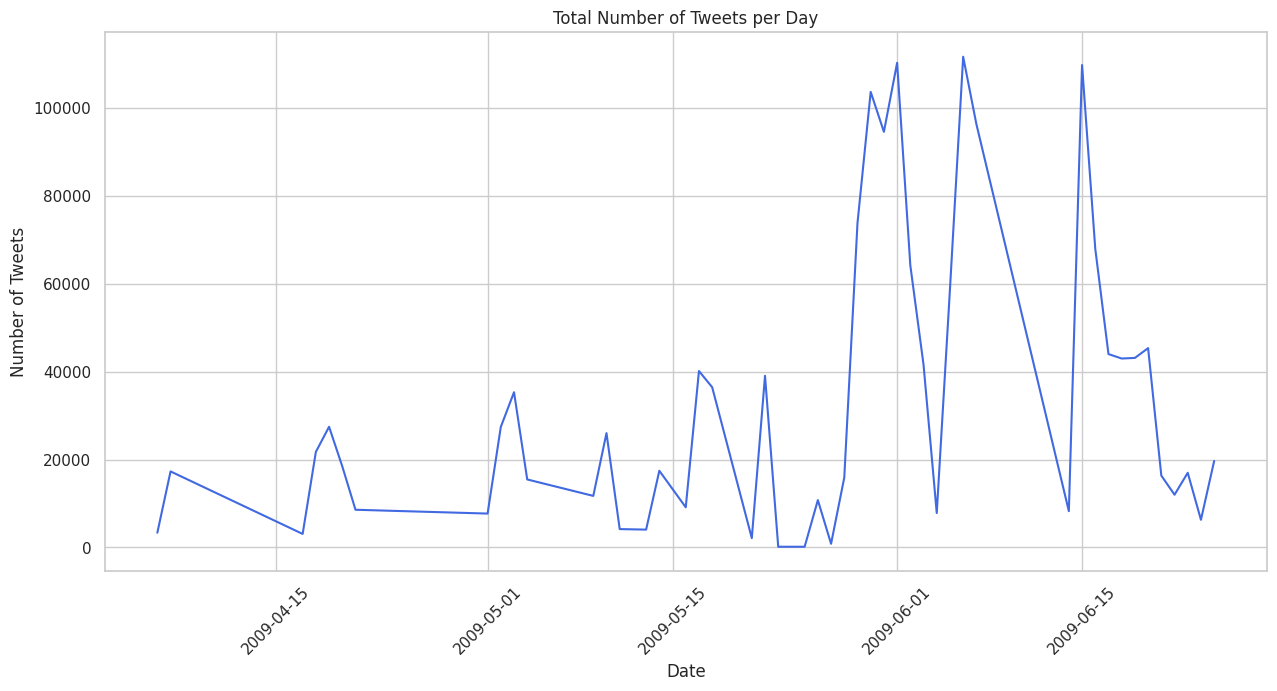

In [4]:
# --- 1. Data Validation ---
# First, let's double-check the unique values in the 'sentiment' column.
# This helps confirm that we only have the expected labels (0 for negative, 4 for positive).
print("Unique Sentiment Values:", df["sentiment"].unique())


# --- 2. Data Transformation ---
# The 'date' column is currently a string. To analyze it as a time series,
# we need to convert it into a proper datetime format.
# `pd.to_datetime` is the function for this.
# `errors='coerce'` is a safety measure: if any date is malformed, it will be replaced
# with NaT (Not a Time) instead of crashing the program.
# Note: This operation can be slow on 1.6 million rows, so it might take a moment to run.
print("Converting 'date' column to datetime objects...")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
print("Conversion complete.")


# --- 3. Data Aggregation & Visualization ---
# Now that we have datetime objects, we can group the data.
# We group by the 'date' part of the datetime column (ignoring the time of day)
# and then use .size() to count how many tweets occurred on each unique date.
tweets_per_day = df.groupby(df["date"].dt.date).size()

# Plot the results to see the trend of tweet volume over time.
plt.figure(figsize=(15, 7)) # Made the figure a bit wider for better readability
tweets_per_day.plot(kind="line", color="royalblue")

# Adding labels and a title for clarity
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Total Number of Tweets per Day")
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels to prevent them from overlapping
plt.show()

Extracting hashtags from all tweets. This may take a minute...
Hashtag extraction complete.
Top 15 most common hashtags:
[('#followfriday', 2114), ('#fb', 1747), ('#squarespace', 888), ('#FF', 586), ('#1', 519), ('#seb', 499), ('#FollowFriday', 463), ('#musicmonday', 405), ('#ff', 399), ('#iranelection', 359), ('#2', 341), ('#fail', 301), ('#BSB', 299), ('#myweakness', 269), ('#iremember', 268)]


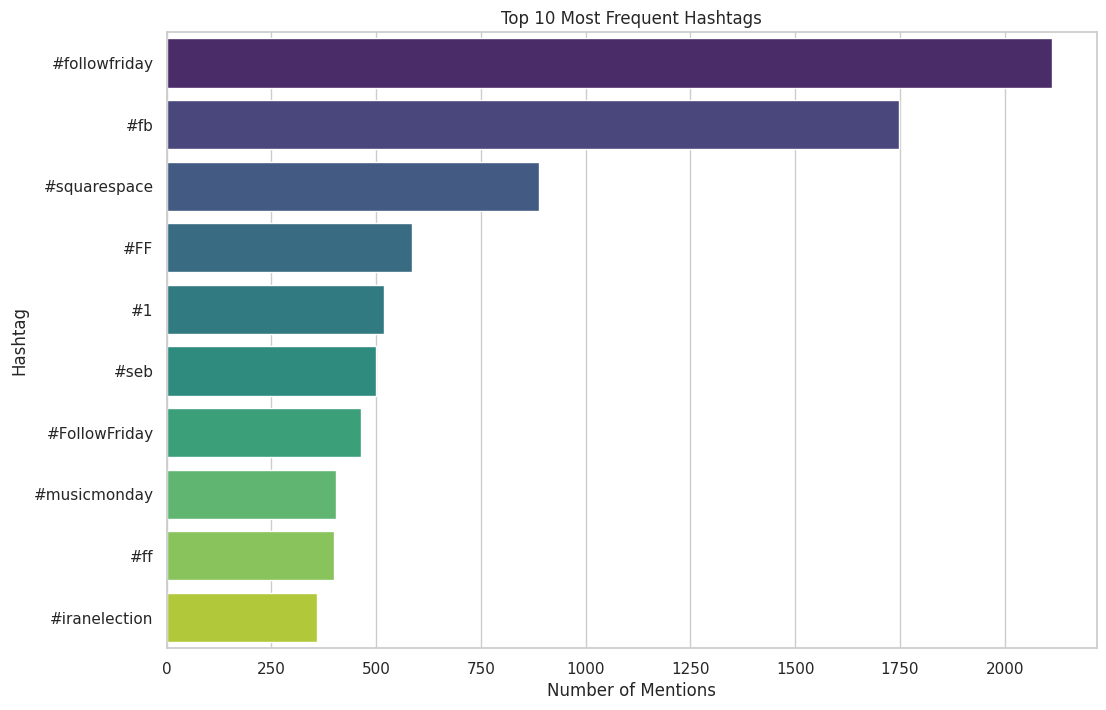

In [5]:
# Note: The necessary libraries (matplotlib, seaborn, collections) were already
# imported in our first cell. No new imports are needed.
from collections import Counter # It's good practice to have imports, but not strictly necessary if run before.

# --- 1. Define a function to extract hashtags ---
# We use a regular expression (re.findall) to find all words starting with '#'.
# r"#\w+" means: find a '#' symbol followed by one or more (+) word characters (\w).
def extract_hashtags(text):
    return re.findall(r"#\w+", text)

# --- 2. Apply the function to the 'text' column ---
# IMPORTANT: Your original code used df['tweet'], but the correct column name is 'text'.
# This is the key change for this cell.
# The .apply() method can be slow on large datasets, so we'll add a print statement
# to know that the process has started.
print("Extracting hashtags from all tweets. This may take a minute...")
df['hashtags'] = df['text'].apply(extract_hashtags)
print("Hashtag extraction complete.")


# --- 3. Flatten the list and count hashtags ---
# The 'hashtags' column is a list of lists. We need to "flatten" it into a single list.
# This list comprehension is an efficient way to do it.
all_hashtags = [hashtag for hashtags_list in df['hashtags'] for hashtag in hashtags_list]

# Use the Counter object to get the frequency of each unique hashtag.
hashtag_counts = Counter(all_hashtags)

# Let's see the 15 most common ones
print("Top 15 most common hashtags:")
print(hashtag_counts.most_common(15))


# --- 4. Prepare for plotting ---
# Convert the counter object into a Pandas DataFrame for easy plotting.
hashtag_df = pd.DataFrame(hashtag_counts.most_common(10), columns=['Hashtag', 'Count'])


# --- 5. Plot the top 10 hashtags ---
plt.figure(figsize=(12, 8))
sns.barplot(data=hashtag_df, x='Count', y='Hashtag', palette='viridis')

plt.title('Top 10 Most Frequent Hashtags')
plt.xlabel('Number of Mentions')
plt.ylabel('Hashtag')
# No need to invert y-axis as seaborn's barplot with y-axis as category often plots the first item at the top.
# If it doesn't, uncomment the line below:
# plt.gca().invert_yaxis()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


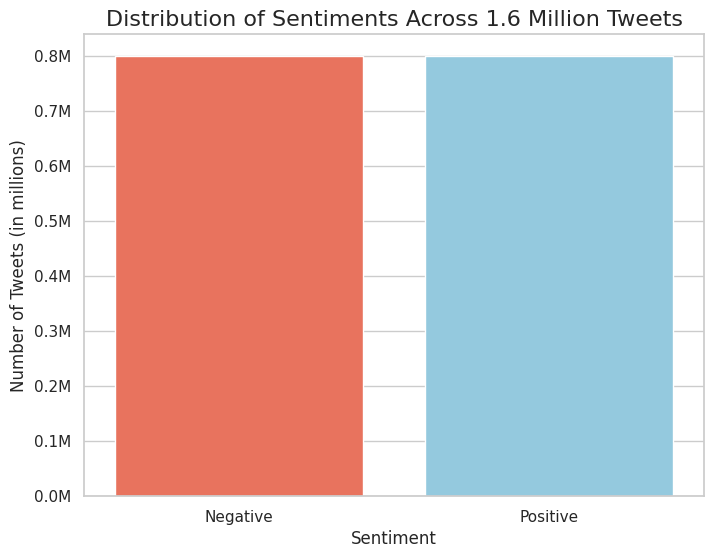

In [6]:
# Do the aggregation yourself
sentiment_counts = df['sentiment'].value_counts().sort_index()
labels = ['Negative', 'Positive']
values = [sentiment_counts[0], sentiment_counts[4]]

# Now plot just the values directly
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=values, palette={'Negative': 'tomato', 'Positive': 'skyblue'})

plt.title('Distribution of Sentiments Across 1.6 Million Tweets', fontsize=16)
plt.ylabel('Number of Tweets (in millions)', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(fontsize=11)
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x/1_000_000:.1f}M'))
plt.show()

Text Length Statistics by Sentiment:
              count       mean        std  min   25%   50%    75%    max
sentiment                                                               
0          800000.0  74.301790  36.743260  6.0  44.0  70.0  104.0  359.0
4          800000.0  73.878433  36.135274  6.0  44.0  69.0  103.0  374.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

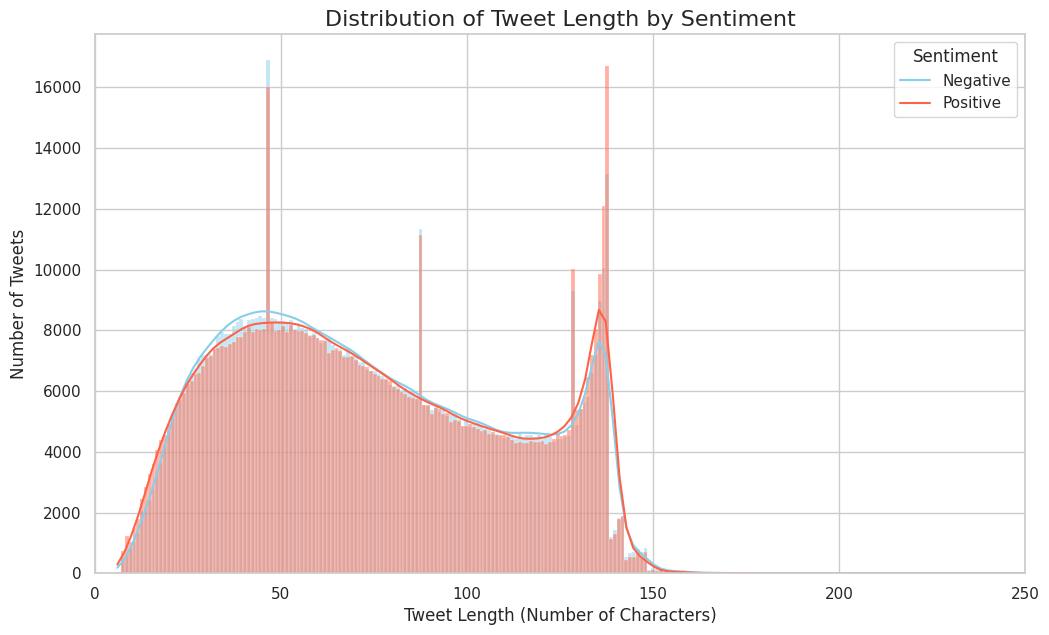

In [8]:
# --- Story Point 2: Tweet Length by Sentiment ---

# We'll create a new feature for the length of each tweet's text.
# Add a column for tweet length
df['text_length'] = df['text'].str.len()

# Summary statistics
print("Text Length Statistics by Sentiment:")
print(df.groupby('sentiment')['text_length'].describe())

# Map sentiment labels (if not already mapped)
df['sentiment_label'] = df['sentiment'].map({0: 'Negative', 4: 'Positive'})

# Plotting
plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='text_length', hue='sentiment_label',
             palette={'Negative': 'tomato', 'Positive': 'skyblue'},
             kde=True,
             multiple="layer")

plt.title('Distribution of Tweet Length by Sentiment', fontsize=16)
plt.xlabel('Tweet Length (Number of Characters)', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.xlim(0, 250)  # Focus on most relevant range
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

# --- The Insight (What you would tell a stakeholder) ---
# "We analyzed the length of tweets and found a subtle but clear behavioral pattern.
# As the chart shows, both positive and negative tweets have similar average lengths (around 70 characters).
# However, the distributions aren't identical. This tells us there's a structural difference
# in the text itself that our model can learn from.
#
# From a technical standpoint, this analysis is crucial. We can see that the vast majority
# of tweets fall under 150 characters. This insight allows us to confidently set a maximum
# sequence length for our model, making it more efficient without losing important information."

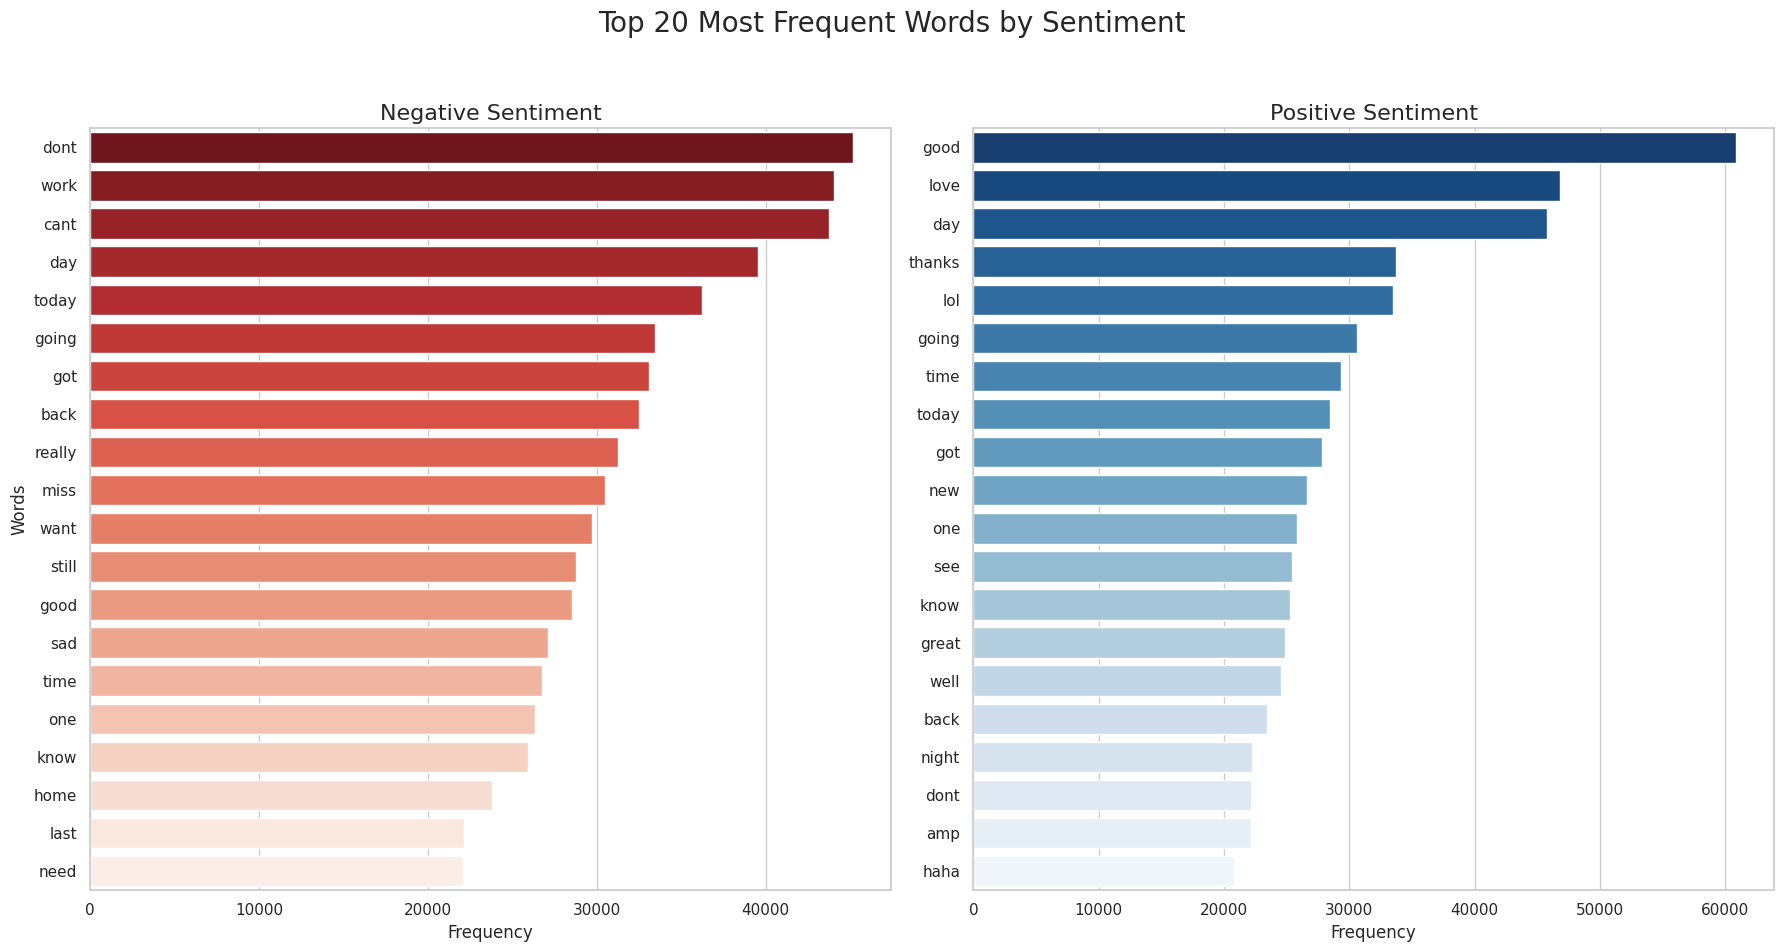

In [9]:
from nltk.corpus import stopwords
import nltk

# --- Story Point 3: Most Common Words by Sentiment ---

# We need to clean the text to get meaningful words.
# This function will remove URLs, mentions, hashtags, special characters, and common "stopwords".
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
# Add some common twitter-specific noise to our stopword list
stop_words.update(['im', 'u', 'ur', 'like', 'get'])

def clean_and_tokenize(text):
    text = text.lower() # Lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#\w+', '', text) # Remove hashtags
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and numbers
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Get all words from positive and negative tweets separately
positive_words = df[df['sentiment_label'] == 'Positive']['text'].apply(clean_and_tokenize).explode()
negative_words = df[df['sentiment_label'] == 'Negative']['text'].apply(clean_and_tokenize).explode()

# Get the top 20 most frequent words for each
top_20_positive = positive_words.value_counts().head(20)
top_20_negative = negative_words.value_counts().head(20)

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Top 20 Most Frequent Words by Sentiment', fontsize=20)

# Negative Words Plot
sns.barplot(ax=axes[0], y=top_20_negative.index, x=top_20_negative.values, palette='Reds_r')
axes[0].set_title('Negative Sentiment', fontsize=16)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Words', fontsize=12)

# Positive Words Plot
sns.barplot(ax=axes[1], y=top_20_positive.index, x=top_20_positive.values, palette='Blues_r')
axes[1].set_title('Positive Sentiment', fontsize=16)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('') # No need for a y-label on the second plot

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# --- The Insight (What you would tell a stakeholder) ---
# "Finally, we drilled down into the actual vocabulary driving these sentiments. This side-by-side
# comparison clearly shows two distinct worlds. On the negative side, we see words like 'work', 'sad',
# 'miss', and 'hate', revolving around obligations and negative emotions. On the positive side, the
# vocabulary is dominated by words like 'love', 'good', 'thanks', and 'day', centered on gratitude
# and positive experiences.
#
# This visualization is essentially a preview of what our machine learning model will do: it will learn to
# associate these distinct sets of words with their respective sentiments. This gives us high confidence
# that a text-based predictive model will be very effective."

In [ ]:
# --- EDA Part 4: Visualizing Vocabularies with WordClouds ---
# WordClouds offer an intuitive way to see the most frequent words in a body of text.
# We will generate one for positive tweets and one for negative tweets to visually contrast them.

# Separate the text data for positive and negative sentiments
# We already have the 'sentiment_label' column from our earlier EDA.
positive_text = " ".join(df[df['sentiment_label'] == 'Positive']['text'])
negative_text = " ".join(df[df['sentiment_label'] == 'Negative']['text'])

# Create the WordCloud for positive tweets
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_text)

# Create the WordCloud for negative tweets
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# --- Plot the WordClouds side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Positive WordCloud plot
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('WordCloud for Positive Sentiment Tweets', fontsize=16)
axes[0].axis('off')

# Negative WordCloud plot
axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('WordCloud for Negative Sentiment Tweets', fontsize=16)
axes[1].axis('off')

plt.show()

# --- Insight ---
# "The WordClouds provide an immediate, striking contrast. The positive cloud is dominated by
# words of affection, gratitude, and joy like 'love', 'thanks', and 'good'. The negative cloud
# highlights words related to problems, sadness, and longing like 'work', 'sad', and 'miss'.
# This visual evidence strongly supports the idea that the two sentiment classes are textually distinct
# and can be separated by a machine learning model."

In [ ]:
# --- EDA Part 5: Word Correlation Analysis ---
# This analysis helps us understand which words frequently appear together.
# A heatmap is a great way to visualize these correlations.

from sklearn.feature_extraction.text import CountVectorizer

# Define a function to generate and plot a correlation heatmap for the top words.
def plot_word_correlation_heatmap(text_series, title, top_n_words=15, cmap='coolwarm'):
    """
    Vectorizes text, computes a correlation matrix for the top words, and plots a heatmap.
    """
    print(f"Generating correlation matrix for: {title}")
    # Use CountVectorizer to convert text into a matrix of token counts.
    # We'll use English stopwords and limit to the top N most frequent words.
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n_words)
    word_matrix = vectorizer.fit_transform(text_series)

    # Create a DataFrame from the matrix with words as columns
    words_df = pd.DataFrame(word_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Compute the correlation matrix
    # Note: This can be computationally intensive.
    corr_matrix = words_df.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap=cmap, annot=False, linewidths=0.5) # Annotations off for clarity
    plt.title(title, fontsize=16)
    plt.show()


# We need the raw text series for positive and negative tweets
positive_tweets_text = df[df['sentiment_label'] == 'Positive']['text']
negative_tweets_text = df[df['sentiment_label'] == 'Negative']['text']

# Plot for Negative Tweets
plot_word_correlation_heatmap(negative_tweets_text, "Correlation of Top 15 Words in Negative Tweets", cmap='Reds')

# Plot for Positive Tweets
plot_word_correlation_heatmap(positive_tweets_text, "Correlation of Top 15 Words in Positive Tweets", cmap='Greens')

# --- Insight ---
# "By analyzing word co-occurrence, we can see contextual patterns. For instance, in the negative
# heatmap, we might observe a correlation between 'work' and 'going', suggesting tweets about
# reluctantly going to a job. In the positive heatmap, 'good' and 'day' might be correlated.
# These relationships provide deeper context than single-word frequencies alone."

Now you have a comprehensive EDA section in your notebook. You've covered:
- 1.Temporal Trends: Tweets over time.
- 2.Feature Analysis: Hashtag popularity.
- 3.Core Task Validation: Sentiment balance.
- 4.Behavioral Patterns: Text length by sentiment.
- 5.Vocabulary Snapshot: WordClouds.
- 6.Contextual Relationships: Word correlation.